# Redes Neuronales - Trabajo Práctico N°2

## Ejercicio 1 - Predictor de diabetes con regresión logística

En primer lugar, importamos los módulos y librerías que usaremos durante el trabajo. Usamos NumPy para los desarrollos numéricos, Keras para los modelos predictivos, pandas para la manipulación de los datos, MatPlotLib y Seaborn para la visualización, y Sklearn para funcionalidades específicas.

In [ ]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.regularizers import l1, l2

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as scaler
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Limpieza inicial de datos

Para empezar, se cargaron los datos y se reemplazaron a los datos inválidos por NaN (valores nulos en columnas como presión sanguínea, glucosa o insulina). También se separó a los datos en train (64%), validación (16%) y test (20%).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/TP2/Ejercicio 1/diabetes.csv')
df = df.replace(0, np.nan)
df[['Pregnancies', 'Outcome']] = df[['Pregnancies', 'Outcome']].replace(np.nan, 0)

train_data, test_data = train_test_split(df, test_size = .2, random_state = 0, shuffle = True)
train_data, validation_data = train_test_split(train_data, test_size = .2, random_state = 0, shuffle = True)

grouped = train_data.groupby('Outcome')

Luego, en los datos de entrenamiento, se reemplazó a los valores NaN por la media según la clase (media de diabetes para las entradas de diabetes y lo mismo con no diabetes). En los datos de validación, se reemplazó con la media total de los datos de entrenamiento, independientemente de la clase.

También se normalizaron las distintas columnas al Z-Score.

In [ ]:
train_data_r = train_data.copy()
train_data_r[train_data_r['Outcome'] == 0] = train_data_r[train_data_r['Outcome'] == 0].fillna(grouped.get_group(0).mean())
train_data_r[train_data_r['Outcome'] == 1] = train_data_r[train_data_r['Outcome'] == 1].fillna(grouped.get_group(1).mean())

val_data_r = validation_data.fillna(train_data_r.mean())

test_data_r = test_data.fillna(train_data_r.mean())

train_cols = train_data.columns[list(map(lambda v: v not in ['Insulin', 'Outcome'], train_data.columns))]

sc = scaler()

train_data_r = np.hstack((sc.fit_transform(train_data_r[train_cols]), train_data_r['Outcome'].to_numpy().reshape(-1, 1)))
val_data_r = np.hstack((sc.transform(val_data_r[train_cols]), val_data_r['Outcome'].to_numpy().reshape(-1, 1)))
test_data_r = np.hstack((sc.transform(test_data_r[train_cols]), test_data_r['Outcome'].to_numpy().reshape(-1, 1)))

train_data_r = pd.DataFrame(train_data_r, columns = np.append(train_cols, 'Outcome'))
val_data_r = pd.DataFrame(val_data_r, columns = np.append(train_cols, 'Outcome'))
test_data_r = pd.DataFrame(test_data_r, columns = np.append(train_cols, 'Outcome'))

## Definición de métricas

A continuación se definieron distintas funciones para obtener distintas métricas a partir de datos reales y los predecidos. 

Valor predictivo negativo: $\frac{V_N}{P_N}$

Especificidad: $\frac{V_N}{I_N}$

Sensibilidad: $\frac{V_P}{I_P}$

Valor predictivo positivo: $\frac{V_P}{P_P}$

Accuracy: $\frac{V_N + V_P}{P_P + P_N + I_N + I_P}$

Donde el prefijo $V$ hace referencia a "verdadero", el prefijo $I$ hace referencia al input, el prefijo $P$ hace referencia a las predicciones, el sufijo $P$ hace referencia a los positivos y el sufijo $N$ hace referencia a los negativos.

También se definió el $F_{\beta}$ score = $\frac{(1 + \beta^2) \cdot V_P}{(1 + \beta^2) \cdot V_P + \beta^2 \cdot F_N + F_P}$.

Donde $F_N$ y $F_P$ son los falsos negativos y los falsos positivos, respectivamente. Tomando esto, se tendrá que $I_N$ = $F_P + V_N$ y que $I_P$ = $F_N + V_P$.

In [ ]:
def v_pred_neg(y_ok, y_pred):
    return np.count_nonzero(~y_ok & ~y_pred) / np.count_nonzero(~y_pred)

def specif(y_ok, y_pred):
    return np.count_nonzero(~y_ok & ~y_pred) / np.count_nonzero(~y_ok)

def sensib(y_ok, y_pred):
    return np.count_nonzero(y_pred & y_ok) / np.count_nonzero(y_ok)

def v_pred_pos(y_ok, y_pred):
    return np.count_nonzero(y_pred & y_ok) / np.count_nonzero(y_pred)

def accuracy(y_ok, y_pred):
    return np.count_nonzero(y_pred == y_ok) / y_pred.size

def metrics(y_ok, y_pred):
    return ['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg'], np.array([accuracy(y_ok, y_pred), sensib(y_ok, y_pred), specif(y_ok, y_pred), v_pred_pos(y_ok, y_pred), v_pred_neg(y_ok, y_pred)])

def fb_score(y_ok, y_pred, b):
    tp = np.count_nonzero(y_ok & y_pred)
    fn = np.count_nonzero(y_ok & ~y_pred)
    fp = np.count_nonzero(~y_ok & y_pred)
    
    return (1 + b**2) * tp / ((1 + b**2) * tp + b**2 * fn + fp)

def find_maxf2score(mod, train, step):
    thresholds = np.arange(step, 1, step)

    res = np.zeros((2, thresholds.size))
    res[0] = thresholds

    y_ok = train[:, -1].astype(bool)
    y_pred_int = mod.predict(train[:, :-1]).reshape(-1)

    res[1] = [fb_score(y_ok, y_pred_int > th, 2) for th in thresholds]
    max_f2score = np.argwhere(res[1] == res[1].max()).reshape(-1)
    return res[:, max_f2score]

## Regresión Logística

### Binary-Crossentropy

Para la regresión logística, se probaron distintas combinaciones de batch_size, cantidad de epochs, learning rate, optimizador y early_stopping. La mejor combinación encontrada fue la siguiente:

*   Batch_size = 32
*   Epochs = 1000
*   Learning rate: $10^{-3}$ (por defecto).
*   Optimizador: Adam.
*   Early stopping: 200

Estos parámetros no sólo tienen en cuenta el resultado final de la métrica, sino también el tiempo de entrenamiento.

Cabe destacar que en este caso se utilizó el Binary-Crossentropy como función de costo y al área bajo la curva ROC (AUC) como métrica del modelo. Como función de activación, se utilizó una sigmoidea.

In [ ]:
optimizer='adam'
batch_size = 32
epochs = 1000

early_stopping = EarlyStopping(patience = 200, monitor = 'loss')

model = Sequential()
layer = Dense(1, input_shape = (train_cols.size,), activation = 'sigmoid', use_bias = True, kernel_initializer = RandomNormal(0, 1), bias_initializer='zeros')
model.add(layer)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['AUC'])

history = model.fit(train_data_r[train_cols], train_data_r['Outcome'], verbose = 0, epochs=epochs, batch_size=batch_size,shuffle = True, callbacks = [early_stopping])

Para verificar los resultados, se evaluó al modelo con los datos de entrenamiento, obteniendo una loss de 0.4733 y un AUC de 0.839. Estos valores se compararon con distintas combinaciones de hiperparámetros, y se concluyó que son resultados satisfactorios para un primer modelo básico de una capa y una neurona.

In [ ]:
model.evaluate(train_data_r[train_cols], train_data_r['Outcome'], verbose = 1)

16/16 [==============================] - 1s 2ms/step - loss: 0.4733 - auc: 0.8393


[0.4732872247695923, 0.8392585515975952]

Luego se tomaron los datos efectivamente predecidos para el entrenamiento, y se buscó el threshold que maximizara el $F_2$ score. Como se puede ver, se encontró que el threshold óptimo estaba en 0.147. Con este valor, el $F_2$ score será de 0.81. Esto da la pauta de que hay una relación satisfactoria entre las predicciones positivas y negativas, y que el modelo no está decayendo en la implementación trivial.

In [ ]:
y_pred = model.predict(train_data_r[train_cols]).reshape(-1)
max_th, f2score = find_maxf2score(model, np.hstack((train_data_r[train_cols].to_numpy(), train_data_r['Outcome'].to_numpy().reshape(-1, 1))), 1e-3)[:, 0]
print('Threshold:', max_th, '\nF2 score:', f2score)

Threshold: 0.147 
F2 score: 0.8125


Con este threshold encontrado, se evaluaron todas las otras métricas mencionadas previamente. Se puede observar que los resultados maximizaron la sensibilidad y el valor predictivo negativo, sin decaer en el caso trivial, ya que la distribución inicial es de aproximadamente 65% sin diabetes y 35% con diabetes.

In [ ]:
names, vals = metrics(train_data_r['Outcome'].astype(bool), y_pred > max_th)
print(names)
print(vals)

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.6395112  0.96571429 0.45886076 0.49705882 0.9602649 ]


Luego evaluamos la predicción del modelo para la validación, observándose resultados similares al entrenamiento tanto para la loss como para el AUC. Esto da la pauta de que no hay altos niveles de overfitting.

In [ ]:
model.evaluate(val_data_r[train_cols], val_data_r['Outcome'], verbose = 0)

[0.48826533555984497, 0.8162055015563965]

El procedimiento anterior se aplicó también a los datos de validación, pero usando el threshold encontrado para los datos de entrenamiento. Como se observa, las métricas en general tienen un comportamiento comparable a las de los datos de entrenamiento, incluyendo también al $F_2$ score.

In [ ]:
y_pred_val = model.predict(val_data_r[train_cols]).reshape(-1)
names_val, vals_val = metrics(val_data_r['Outcome'].astype(bool), y_pred_val > max_th)
print(names_val)
print(vals_val)
f2score_val = fb_score(val_data_r['Outcome'].astype(bool), y_pred_val > max_th, 2)
print('\nF2 score:', f2score_val)

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.59349593 0.97826087 0.36363636 0.4787234  0.96551724]

F2 score: 0.8093525179856115


A continuación, se realizaron los gráficos del mapeo de los datos al pasar a través del modelo, tanto para el entrenamiento como para la validación. Como se observa, el modelo separa de cierta forma a los datos, pero se puede ver claramente que no hay un alto grado de separabilidad lineal a la salida.

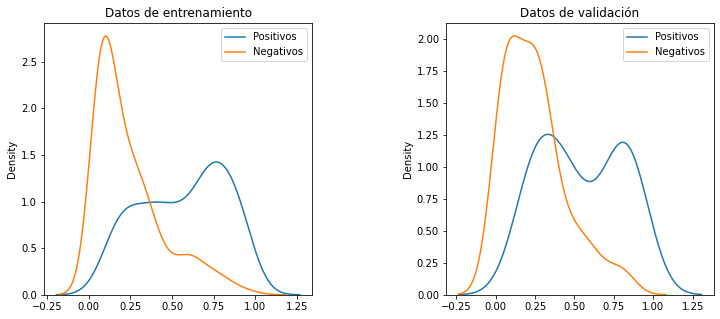

In [ ]:
out_train = model.predict(train_data_r[train_cols]).reshape(-1)
pos_train = out_train[train_data_r['Outcome'] == 1]
neg_train = out_train[train_data_r['Outcome'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.kdeplot(pos_train, label = 'Positivos', ax = ax1);
sns.kdeplot(neg_train, label = 'Negativos', ax = ax1);
ax1.set_title('Datos de entrenamiento');

out_val = model.predict(val_data_r[train_cols]).reshape(-1)
pos_val = out_val[val_data_r['Outcome'] == 1]
neg_val = out_val[val_data_r['Outcome'] == 0]

sns.kdeplot(pos_val, label = 'Positivos', ax = ax2);
sns.kdeplot(neg_val, label = 'Negativos', ax = ax2);
ax2.set_title('Datos de validación');

fig.subplots_adjust(wspace = .5)
ax1.legend(); ax2.legend();

Luego se graficaron las curvas ROC para ambos casos. Se puede ver claramente que la curva de entrenamiento es más "alta", es decir, se acerca a 1 más rápidamente que los de validación, lo cual tiene sentido. Sin embargo, como se calculó antes, ambas mantienen un grado similar de área bajo la curva, con lo cual el modelo es satisfactorio.

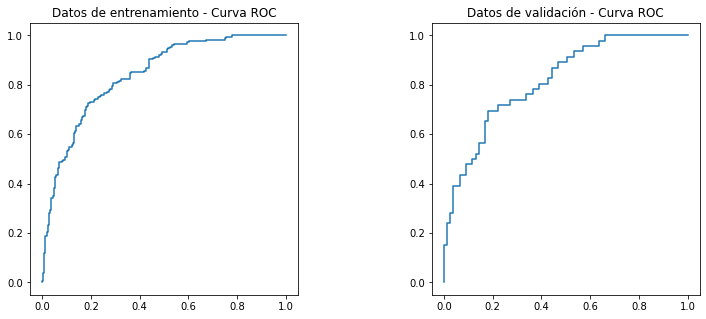

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_data_r['Outcome'], out_train)
fpr_val, tpr_val, thresholds_val = roc_curve(val_data_r['Outcome'], out_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.set_title('Datos de entrenamiento - Curva ROC');
ax1.plot(fpr_train, tpr_train)

ax2.set_title('Datos de validación - Curva ROC');
ax2.plot(fpr_val, tpr_val)

fig.subplots_adjust(wspace = .5)

## Regresión Logística + feature engineering

Luego, se realizó un procesamiento de los datos con el mismo modelo anterior, pero haciendo feature engineering con los datos de entrada. Comparando entre distintos órdenes de features polinomiales, se encontró que el que mejor funcionaba era de orden 5, ya que grados más altos no presentaban mejoras apreciables, aunque sí generaban cierto nivel de overfitting, a pesar de tener regularizaciones en el entrenamiento.

### Binary-Crossentropy

La función $\textit{poly_and_normalize}$ recibe los datos de entrada, el orden del polinomio, las columnas a utilizar y la columna de salida. Devuelve el resultado de feature engineering con el orden elegido y normalizado a Z-Score, y los datos de salida.

In [ ]:
poly_order = 5
features = PolynomialFeatures(poly_order, include_bias = False)
poly_scaler = scaler()

def poly_and_normalize(data, cols, out_col, istrain = False):

    if istrain: res = poly_scaler.fit_transform(features.fit_transform(data[cols]))
    else: res = poly_scaler.transform(features.transform(data[cols]))

    res_out = data[out_col]
    
    return res, res_out

In [ ]:
train_features, train_out = poly_and_normalize(train_data_r, train_cols, 'Outcome', True)
val_features, out_val = poly_and_normalize(val_data_r, train_cols, 'Outcome', False)

Para este modelo, se utilizó la siguiente configuración:

*   Batch_size = 32
*   Epochs = 1000
*   Learning rate: $10^{-3}$ (por defecto).
*   Optimizador: Adam.
*   Early stopping: 100

También se utilizó regularización $L_2$ con $\lambda$ = $150^{-3}$ tanto para los pesos como para el bias.

In [ ]:
optimizer = 'adam'
batch_size = 32
epochs = 1000

early_stopping = EarlyStopping(patience = 100, monitor = 'loss')
model_2 = Sequential()
layer = Dense(
      1, 
      input_shape=(train_features.shape[1],),
      activation='sigmoid',
      use_bias=True,
      kernel_initializer=RandomNormal(0, 1),
      bias_initializer='zeros',
      bias_regularizer = l2(150e-3),
      kernel_regularizer = l2(150e-3)
)
model_2.add(layer)
model_2.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics=['AUC'])

history = model_2.fit(train_features, train_out, verbose = 0, epochs=epochs, batch_size=batch_size,shuffle = True, callbacks = [early_stopping])

Al verificar los resultados, se puede ver que el área de curva ROC para el entrenamiento mejoró considerablemente con respecto al caso anterior.

In [ ]:
model_2.evaluate(train_features, train_out, verbose = 0)

[0.49360644817352295, 0.9028119444847107]

Como se puede observar, el threshold que maximiza el $F_2$ score encontrado para los features polinomiales es 0.31, con un $F_2$ score de 0.84, que es mayor que en el caso anterior.

In [ ]:
y_pred_2 = model_2.predict(train_features).reshape(-1)
max_th_2, f2score_2 = find_maxf2score(model_2, np.hstack((train_features, train_data_r['Outcome'].to_numpy().reshape(-1, 1))), step = 1e-3)[:, 0]
print('Threshold:', max_th_2, '\nF2 score:', f2score_2)

Threshold: 0.31 
F2 score: 0.8398821218074656


En cuanto a la validación, si bien ésta mejoró con respecto al caso anterior, con lo cual el modelo está introduciendo una clara mejora, se puede ver que este valor es bastante menor que para el entrenamiento. Esto da indicio de que el modelo está aprendiendo con cierto grado de overfitting. Distintas combinaciones de los parámetros de regularización no ayudaron a mejorar este comportamiento a niveles mayores al encontrado.

In [ ]:
model_2.evaluate(val_features, out_val, verbose = 0)

[0.5393021702766418, 0.8529080152511597]

El comportamiento previamente mencionado también se evidencia al calcular el $F_2$ score con el threshold encontrado. Se puede ver que el nuevo $F_2$ score para validación es similar al caso anterior, pero menor que el de entrenamiento, lo cual da evidencia de overfitting.

In [ ]:
y_pred_val_2 = model_2.predict(val_features).reshape(-1)
names_val_2, vals_val_2 = metrics(val_data_r['Outcome'].astype(bool), y_pred_val_2 > max_th_2)
print(names_val)
print(vals_val_2)
f2score_val_2 = fb_score(val_data_r['Outcome'].astype(bool), y_pred_val_2 > max_th_2, 2)
print('\nF2 score:', f2score_val_2)

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.61788618 0.97826087 0.4025974  0.49450549 0.96875   ]

F2 score: 0.8181818181818182


Al igual que en el caso anterior, se muestra el mapeo de los datos y la curva ROC.

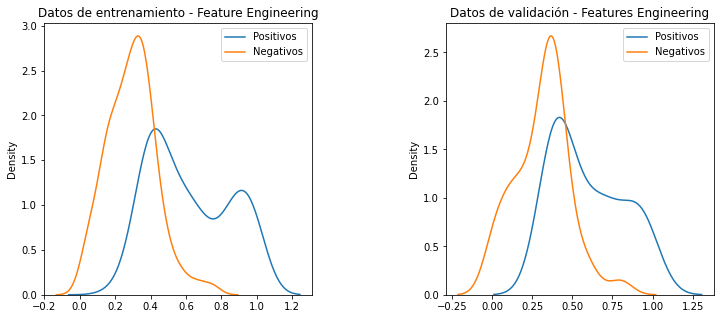

In [ ]:
out_train_features = model_2.predict(train_features).reshape(-1)
pos_train_features = out_train_features[train_data_r['Outcome'] == 1]
neg_train_features = out_train_features[train_data_r['Outcome'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.kdeplot(pos_train_features, label = 'Positivos', ax = ax1);
sns.kdeplot(neg_train_features, label = 'Negativos', ax = ax1);
ax1.set_title('Datos de entrenamiento - Feature Engineering');

out_val_features = model_2.predict(val_features).reshape(-1)
pos_val_features = out_val_features[val_data_r['Outcome'] == 1]
neg_val_features = out_val_features[val_data_r['Outcome'] == 0]

sns.kdeplot(pos_val_features, label = 'Positivos', ax = ax2);
sns.kdeplot(neg_val_features, label = 'Negativos', ax = ax2);
ax2.set_title('Datos de validación - Features Engineering');

fig.subplots_adjust(wspace = .5)
ax1.legend();
ax2.legend();

Se puede ver que, en este caso, la curva ROC tiende a 1 más rápidamente que en el modelo sin features polinomiales, lo cual es de esperarse. Siguiendo con los resultados obtenidos previamente, también se ve que la curva ROC de validación es notablemente menos pronunciada que la de entrenamiento, dejando ver cierto overfitting que, como se remarcó, no logró solucionarse con parámetros de regularización $L_1$ y $L_2$ para pesos y bias.

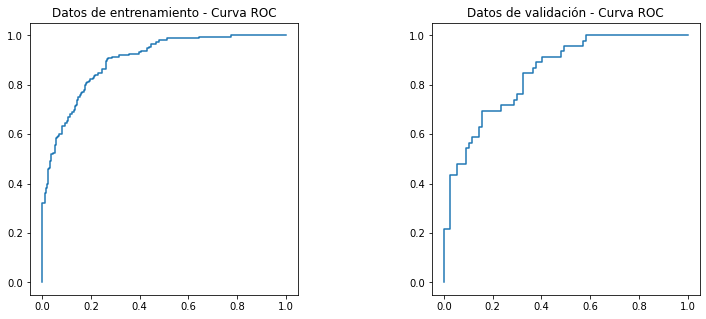

In [ ]:
fpr_train_features, tpr_train_features, thresholds_train_features = roc_curve(train_data_r['Outcome'], out_train_features)
fpr_val_features, tpr_val_features, thresholds_val_features = roc_curve(val_data_r['Outcome'], out_val_features)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.set_title('Datos de entrenamiento - Curva ROC');
ax1.plot(fpr_train_features, tpr_train_features)

ax2.set_title('Datos de validación - Curva ROC');
ax2.plot(fpr_val_features, tpr_val_features)

fig.subplots_adjust(wspace = .5)

## MLP

Por último, se analizaron los datos con un modelo de MLP. Los parámetros utilizados fueron los siguientes:

*   Batch_size = 64
*   Epochs = 2000
*   Learning rate: constante en 0.005
*   Optimizador: Adam.
*   Early stopping: 400

La topología utilizada para la red fue de cuatro capas densas, con dos capas intermedias de BatchNormalization y una de DropOut. La primera capa tiene cuatro neuronas y una función de activación sigmoidea. La segunda y tercera capas densas tienen cuatro y dos neuronas, respectivamente, ambas con función de activación 'relu', y seguidas de capas de BatchNormalization. Luego la de DropOut con factor de 50%. Finalmente, la capa de salida con una neurona y función de activación sigmoidea.

Cabe destacar que en la primera capa se utilizó una regularización $L_2$ de $\lambda$ = $5\cdot 10^{-3}$ para los pesos y para el bias.

In [ ]:
batch_size = 64
epochs = 2000

early_stopping = EarlyStopping(patience = 400, monitor = 'loss')
optimizer = Adam(learning_rate = .005)

outs = [4, 4, 2, 1]
loss = 'binary_crossentropy'
model_3 = Sequential()
model_3.add(
    Dense(outs[0], 
          input_shape = (train_cols.size,), 
          activation = 'sigmoid', 
          kernel_initializer = RandomNormal(0, 1), 
          use_bias = True, 
          bias_initializer = 'zeros',
          kernel_regularizer = l2(5e-3),
          bias_regularizer = l2(5e-3)
      ))
  
for out in outs[1:-1]:
    model_3.add(Dense(out, activation = 'relu', use_bias = True, bias_initializer = 'zeros'))
    model_3.add(BatchNormalization())
  
model_3.add(Dropout(.5))
model_3.add(Dense(outs[-1], activation = 'sigmoid', use_bias = True, bias_initializer = 'zeros'))
model_3.compile(optimizer = optimizer, loss = loss, metrics = ['AUC'])

history = model_3.fit(train_data_r[train_cols], train_data_r['Outcome'], verbose = 0, epochs=epochs, batch_size=batch_size,shuffle = True, callbacks = [early_stopping])

Como se puede ver, los resultados obtenidos fueron levemente menores al caso de features polinomiales, con un AUC de 0.861.

In [ ]:
model_3.evaluate(train_data_r[train_cols], train_data_r['Outcome'])

16/16 [==============================] - 0s 3ms/step - loss: 0.4741 - auc: 0.8615


[0.4740672707557678, 0.8614919185638428]

En este caso, el valor de threshold que maximiza el $F_2$ score es de 0.171, dando un $F_2$ score similar a los casos anteriores, de 0.831.

In [ ]:
y_pred_3 = model_3.predict(train_data_r[train_cols]).reshape(-1)
max_th_3, f2score_3 = find_maxf2score(model_3, np.hstack((train_data_r[train_cols].to_numpy(), train_data_r['Outcome'].to_numpy().reshape(-1, 1))), step = 1e-3)[:, 0]
print('Threshold:', max_th_3, '\nF2 score:', f2score_3)

Threshold: 0.171 
F2 score: 0.8317120622568094


En cuanto a la validación, se puede observar que el AUC es de 0.844, similar a los anteriores, pero se aprecia un menor grado de overfitting que en el modelo anterior.

In [ ]:
model_3.evaluate(val_data_r[train_cols], val_data_r['Outcome'])

4/4 [==============================] - 0s 3ms/step - loss: 0.5020 - auc: 0.8436


[0.5019741058349609, 0.8435911536216736]

Para este caso, el valor del $F_2$ score es de 0.806, nuevamente similar al modelo de features polinomiales. 

In [ ]:
y_pred_val_3 = model_3.predict(val_data_r[train_cols]).reshape(-1)
names_val_3, vals_val_3 = metrics(val_data_r['Outcome'].astype(bool), y_pred_val_3 > max_th_3)
print(names_val)
print(vals_val_3)
f2score_val_3 = fb_score(val_data_r['Outcome'].astype(bool), y_pred_val_3 > max_th_3, 2)
print('\nF2 score:', f2score_val_3)

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.61788618 0.95652174 0.41558442 0.49438202 0.94117647]

F2 score: 0.8058608058608059


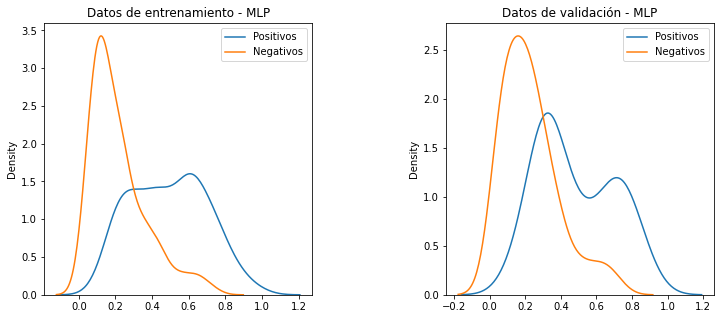

In [ ]:
out_train_mlp = model_3.predict(train_data_r[train_cols]).reshape(-1)
pos_train_mlp = out_train_mlp[train_data_r['Outcome'] == 1]
neg_train_mlp = out_train_mlp[train_data_r['Outcome'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.kdeplot(pos_train_mlp, label = 'Positivos', ax = ax1);
sns.kdeplot(neg_train_mlp, label = 'Negativos', ax = ax1);
ax1.set_title('Datos de entrenamiento - MLP');

out_val_mlp = model_3.predict(val_data_r[train_cols]).reshape(-1)
pos_val_mlp = out_val_mlp[val_data_r['Outcome'] == 1]
neg_val_mlp = out_val_mlp[val_data_r['Outcome'] == 0]

sns.kdeplot(pos_val_mlp, label = 'Positivos', ax = ax2);
sns.kdeplot(neg_val_mlp, label = 'Negativos', ax = ax2);
ax2.set_title('Datos de validación - MLP');

fig.subplots_adjust(wspace = .5)
ax1.legend();
ax2.legend();

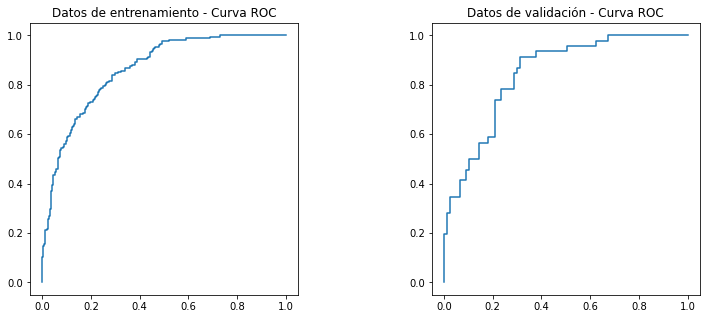

In [ ]:
fpr_train_mlp, tpr_train_mlp, thresholds_train_mlp = roc_curve(train_data_r['Outcome'], out_train_mlp)
fpr_val_mlp, tpr_val_mlp, thresholds_val_mlp = roc_curve(val_data_r['Outcome'], out_val_mlp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.set_title('Datos de entrenamiento - Curva ROC');
ax1.plot(fpr_train_mlp, tpr_train_mlp)

ax2.set_title('Datos de validación - Curva ROC');
ax2.plot(fpr_val_mlp, tpr_val_mlp)

fig.subplots_adjust(wspace = .5)

Finalmente, se probaron todos los modelos con el subset de test.

Con respecto al primer modelo, se puede ver que la métrica principal AUC es de 0.886, con un $F_2$ score de 0.8. Los resultados son favorables comparándolos con los obtenidos en train y validación.

In [ ]:
print('loss, AUC:', model.evaluate(test_data_r[train_cols], test_data_r['Outcome'], verbose = 0),'\n')
y_pred_test = model.predict(test_data_r[train_cols]).reshape(-1)
names_test, vals_test = metrics(test_data_r['Outcome'].astype(bool), y_pred_test > max_th)
print(names_test)
print(vals_test)
f2score_test = fb_score(test_data_r['Outcome'].astype(bool), y_pred_test > max_th, 2)
print('\nF2 score:', f2score_test)

loss, AUC: [0.41156452894210815, 0.8862596154212952] 

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.61688312 1.         0.44859813 0.44339623 1.        ]

F2 score: 0.7993197278911565


Para el modelo de los features polinomiales, el AUC de test es menor que en el modelo anterior pero el $F_2$ score es mayor. Además, las métricas secundarias son mayores. 

In [ ]:
test_features, out_test = poly_and_normalize(test_data_r, train_cols, 'Outcome', istrain = False)
print('loss, AUC:', model_2.evaluate(test_features, out_test, verbose = 0),'\n')
y_pred_test_2 = model_2.predict(test_features).reshape(-1)
names_test_2, vals_test_2 = metrics(out_test.astype(bool), y_pred_test_2 > max_th_2)
print(names_test_2)
print(vals_test_2)
f2score_test_2 = fb_score(out_test.astype(bool), y_pred_test_2 > max_th_2, 2)
print('\nF2 score:', f2score_test_2)

loss, AUC: [0.6289114356040955, 0.864784300327301] 

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.66233766 1.         0.51401869 0.47474747 1.        ]

F2 score: 0.818815331010453


Por último, el modelo con MLP tuvo resultados intermedios. Por un lado presenta un AUC muy similar que en el caso de features polinomiales, y por otro lado, presenta un $F_2$ score como el primero. En cuanto a las métricas secundarias, son más similares al del primer caso.

In [ ]:
print('loss, AUC:', model_3.evaluate(test_data_r[train_cols], test_data_r['Outcome'], verbose = 0),'\n')
y_pred_test_3 = model_3.predict(test_data_r[train_cols]).reshape(-1)
names_test_3, vals_test_3 = metrics(test_data_r['Outcome'].astype(bool), y_pred_test_3 > max_th_3)
print(names_test_3)
print(vals_test_3)
f2score_test_3 = fb_score(test_data_r['Outcome'].astype(bool), y_pred_test_3 > max_th_3, 2)
print('\nF2 score:', f2score_test_3)

loss, AUC: [0.4539213180541992, 0.8656790256500244] 

['Acc', 'Sensib', 'Specif', 'VpPos', 'VpNeg']
[0.6038961  1.         0.42990654 0.43518519 1.        ]

F2 score: 0.793918918918919


Teniendo en cuenta los resultados anteriores, considerando los resultados de la métrica principal y de las secundarias, se considera que el mejor modelo para este problema es el de features polinomiales, cuyas métricas son:

Métrica principal:
*   AUC: 0.865

Métricas secundarias:
*   $F_2$ score: 0.819
*   Accuracy: 66.23%
*   Sensibilidad: 100%
*   Especificidad: 51.40%
*   Valor predictivo positivo: 47.47%
*   Valor predictivo negativo: 100%